In [1]:
import qutip
import numpy as np
from matplotlib import pyplot as plt
import scqubits
from typing import List
from qiskit.algorithms.optimizers import COBYLA,ISRES,CRS,DIRECT_L
from IPython.display import clear_output

In [2]:
g = 0.8

In [22]:
scqubits.GUI(
)

Output(layout=Layout(width='100%'))

In [3]:
def min_detunning_from_g0g1_to_e0e1_f0f1(hilbertspace):
    g0_g1 = hilbertspace.energy_by_dressed_index(hilbertspace.dressed_index((0,1)))* 2 * np.pi \
        -hilbertspace.energy_by_dressed_index(hilbertspace.dressed_index((0,0)))* 2 * np.pi
    e0_e1 = hilbertspace.energy_by_dressed_index(hilbertspace.dressed_index((1,1)))* 2 * np.pi \
            -hilbertspace.energy_by_dressed_index(hilbertspace.dressed_index((1,0)))* 2 * np.pi
    f0_f1 = hilbertspace.energy_by_dressed_index(hilbertspace.dressed_index((2,1)))* 2 * np.pi \
            -hilbertspace.energy_by_dressed_index(hilbertspace.dressed_index((2,0)))* 2 * np.pi
    # h0_h1 = hilbertspace.energy_by_dressed_index(hilbertspace.dressed_index((3,1)))* 2 * np.pi \
    #         -hilbertspace.energy_by_dressed_index(hilbertspace.dressed_index((3,0)))* 2 * np.pi
    min_diff = min([abs(e0_e1-g0_g1),abs(f0_f1-g0_g1)])
    return min_diff

def plot_specturum(qubit, resonator, hilbertspace, max_qubit_level = 4,max_resonator_level=3,
                    flagged_transitions = [[[0,0],[0,1]],[[1,0],[1,1]],[[2,0],[2,1]],[[3,0],[3,1]]],message = ''):
    energy_text_size = 8
    clear_output(wait=True)
    qubit_ori_energies = qubit.eigenvals(max_qubit_level)
    resonator_ori_energies = resonator.eigenvals(max_resonator_level)
    fig, old_ax = qubit.plot_wavefunction(which = [0,1,2,3,4])
    left, bottom, width, height = 1, 0, 1, 1  
    ax = fig.add_axes([left, bottom, width, height])
    fig.set_size_inches(4, 4)
    for ql in range(0,max_qubit_level):
        for rl in range(0,max_resonator_level):
            original = (qubit_ori_energies[ql] + resonator_ori_energies[rl])* 2 * np.pi
            x1,x2 = ql-0.25,ql+0.25
            ax.plot([x1, x2], [original, original], linewidth=1, color='red')
            ax.text(ql, original, f"{original:.3f}", fontsize=energy_text_size, ha='center', va='bottom')

            dressed_state_index = hilbertspace.dressed_index((ql,rl))
            if dressed_state_index != None:
                dressed = hilbertspace.energy_by_dressed_index(dressed_state_index)* 2 * np.pi
                ax.plot([x1, x2], [dressed, dressed], linewidth=1, color='green')
                ax.text(ql, dressed, f"{dressed:.3f}", fontsize=energy_text_size, ha='center', va='top')
            else:
                print("dressed_state_index contain None")

    min_diff = min_detunning_from_g0g1_to_e0e1_f0f1(hilbertspace)
    ax.text(1.5, 0, f"min drive detuning{min_diff:.3f}", fontsize=energy_text_size+4, ha='center', va='center')
    ax.text(1.5, -15, str(message), fontsize=energy_text_size+2, ha='center', va='center')
    for transition in flagged_transitions:
        state1, state2 = transition[0],transition[1]
        dressed_index1 = hilbertspace.dressed_index((state1[0],state1[1]))
        dressed_index2 = hilbertspace.dressed_index((state2[0],state2[1]))
        if dressed_index1!= None and dressed_index2!= None:
            energy1 = hilbertspace.energy_by_dressed_index(dressed_index1)* 2 * np.pi
            energy2 = hilbertspace.energy_by_dressed_index(dressed_index2)* 2 * np.pi
            ax.plot([state1[0], state2[0]], [energy1, energy2], linewidth=1, color='green')
            ax.text((state1[0]+ state2[0])/2, (energy1+ energy2)/2, f"{energy2-energy1:.3f}", fontsize=energy_text_size, ha='center', va='top')
        else:
            print("dressed_state_index contain None")
    plt.show()

def try_system_setup(params,plot=False):
    # print(params)
    fluxonium = scqubits.Fluxonium(EJ = params[0],
                                    EC = params[1],
                                    EL = params[2],
                                    flux = 0,
                                    cutoff = 110)
    osc = scqubits.Oscillator(
        E_osc=params[3],
        l_osc = params[4],
        truncated_dim=8
    )
    hilbertspace = scqubits.HilbertSpace([fluxonium, osc])
    hilbertspace.add_interaction(
        g_strength=g, op1=fluxonium.n_operator, op2=osc.creation_operator, add_hc=True
    )
    hilbertspace.generate_lookup()
    dessed_indices = [hilbertspace.dressed_index((0,0)),
                      hilbertspace.dressed_index((0,1)),
                      hilbertspace.dressed_index((1,0)),
                      hilbertspace.dressed_index((1,1)),
                      hilbertspace.dressed_index((2,0)),
                      hilbertspace.dressed_index((2,1))]
    if None in dessed_indices:
        print("dessed_indices contain None")
        return 0
    if plot:
        plot_specturum(fluxonium, osc, hilbertspace,message = params)
    min_detuning = min_detunning_from_g0g1_to_e0e1_f0f1(hilbertspace)
    # print(min_detuning)
    return -1 * min_detuning


In [4]:
# # optimizer = COBYLA(maxiter=200)
# # optimizer = CRS(max_evals=200)
# optimizer = ISRES(max_evals=200)
# res = optimizer.minimize(
#     fun = optimizer.wrap_function(try_system_setup,args=(True,)),
#     x0 = [8.9,
#             2.5,
#             0.5,
#             7,
#             1],
#     bounds = [(7,12),(2,10),(0.2,0.57),(1,20),(0,3)]
#     )

# params = res.x
# try_system_setup(params,True)

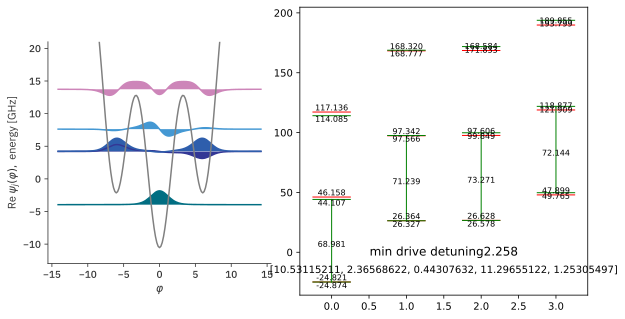

-2.258128490039013

In [34]:
# print(params)
params = [10.53115211,  2.36568622 , 0.44307632, 11.29655122 , 1.25305497]
try_system_setup(params,True)

# Define the system

In [6]:
fluxonium = scqubits.Fluxonium(EJ = params[0],
                                EC = params[1],
                                EL = params[2],
                                flux = 0,
                                cutoff = 110)
osc = scqubits.Oscillator(
    E_osc=params[3],
    l_osc = params[4],
    truncated_dim=8
)
hilbertspace = scqubits.HilbertSpace([fluxonium, osc])
hilbertspace.add_interaction(
    g_strength=g, op1=fluxonium.n_operator, op2=osc.creation_operator, add_hc=True
)
hilbertspace.generate_lookup()


(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
        2 * np.pi * qutip.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
def truncate(operator: qutip.Qobj, dimension: int) -> qutip.Qobj:
    return qutip.Qobj(operator[:dimension, :dimension])
total_truncation = 30
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)



def transition_frequency(s0: int, s1: int) -> float:
    # assert type(s0) == int, 'bad input'
    # assert type(s1) == int, 'bad input'
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2 * np.pi
    )

a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
a = truncate(a, total_truncation)

# Erasure Detection

# The curve of g0 is photon state bounce back quickly, 

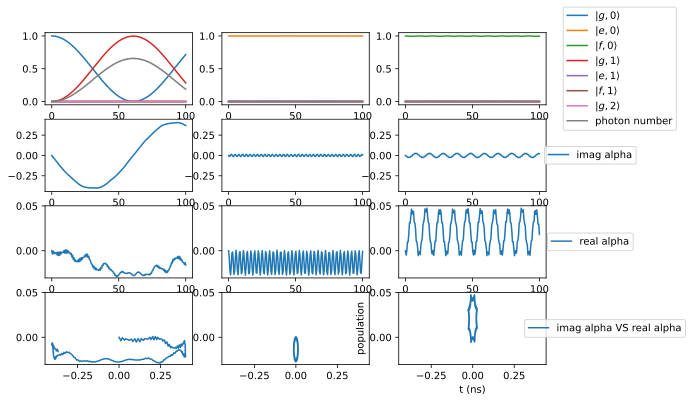

In [21]:
omega_g0g1 = transition_frequency(hilbertspace.dressed_index((0,0)), hilbertspace.dressed_index((0,1)))

A = 0.01
tg = 100 # ns

#cos pulse
def drive_coeff(t: float, *args: dict) -> float:
    return A * np.cos(omega_g0g1 * t)




H_with_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (a+a.dag()) , drive_coeff],  # driving through the resonator
]


product_states = [(0, 0), (1, 0), (2,0), (0, 1), (1, 1), (2,1),(0,2)]
idxs = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states]
qutip_states = [qutip.basis(total_truncation, idx) for idx in idxs]

tlist = np.linspace(0, tg, tg*2)
results = []
for i in range(3):
    temp = qutip.sesolve(
        H = H_with_drive,
        psi0 = qutip.basis(total_truncation, hilbertspace.dressed_index((i,0))),
        tlist = tlist,
        e_ops=[state * state.dag() for state in qutip_states]+[a,
                                                               a.dag()*a, #photon number
                                                            0.5*(a+a.dag()), # real alpha
                                                            -0.5*1j*(a-a.dag())# imag alpha
                                                             ],
        options=qutip.Options(store_final_state=True)
    )
    results.append(temp)

dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}


fig, axes = plt.subplots(4, 3, figsize=(9, 6))




for i in range(3):
    for idx, res in zip(idxs, results[i].expect):
        product_state = product_states[idxs.index(idx)]
        qubit_state = dictionary[product_state[0]]
        resonator_state = product_state[1]
        axes[0][i].plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
    alpha = results[i].expect[-4]*np.exp(1j*omega_g0g1*tlist)
    real = alpha.real
    imag = alpha.imag
    axes[0][i].plot(tlist, results[i].expect[-3], label=r"photon number")
    axes[1][i].plot(tlist,imag , label=r"imag alpha")
    axes[2][i].plot(tlist, real, label=r"real alpha")
    axes[3][i].plot(-imag, real, label=r"imag alpha VS real alpha")

axes[0][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
axes[1][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[2][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[3][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.4, 0.5))
plt.ylabel("population")
plt.xlabel("t (ns)")
for row in range(4):
    max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
    for col in [0,1,2]:
        ymin, ymax = axes[row][col].get_ylim()
        xmin, xmax = axes[row][col].get_xlim()
        if ymax > max_y_range:
            max_y_range = ymax
        if ymin < min_y_range:
            min_y_range = ymin
        if xmax > max_x_range:
            max_x_range = xmax
        if xmin < min_x_range:
            min_x_range = xmin
    for col in [0,1,2]:
        axes[row][col].set_ylim(min_y_range, max_y_range)
        axes[row][col].set_xlim(min_x_range,max_x_range)
# plt.yscale('log')
plt.show()

# Computational state measurement

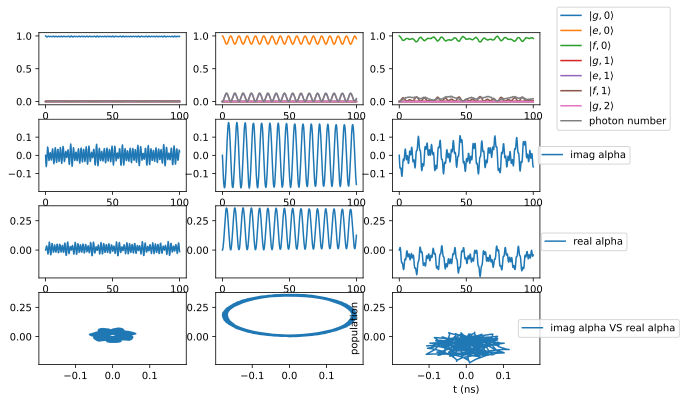

In [10]:
omega_e0e1 = transition_frequency(hilbertspace.dressed_index((1,0)), hilbertspace.dressed_index((1,1)))
omega_f0f1 = transition_frequency(hilbertspace.dressed_index((2,0)), hilbertspace.dressed_index((2,1)))
omega_d = (omega_e0e1+omega_f0f1)/2

A = 0.06
tg = 100 # ns

def drive_coeff(t: float, *args: dict) -> float:
    return A * np.cos(omega_d * t)


H_with_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (a+a.dag()) , drive_coeff],  # driving through the resonator
]


product_states = [(0, 0), (1, 0), (2,0), (0, 1), (1, 1), (2,1),(0,2)]
idxs = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states]
qutip_states = [qutip.basis(total_truncation, idx) for idx in idxs]

tlist = np.linspace(0, tg, tg*4)
results = []
for i in range(3):
    temp = qutip.sesolve(
        H = H_with_drive,
        psi0 = qutip.basis(total_truncation, hilbertspace.dressed_index((i,0))),
        tlist = tlist,
        e_ops=[state * state.dag() for state in qutip_states]+[a,
                                                               a.dag()*a, #photon number
                                                            0.5*(a+a.dag()), # real alpha
                                                            -0.5*1j*(a-a.dag())# imag alpha
                                                             ],
        options=qutip.Options(store_final_state=True)
    )
    results.append(temp)

dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}


fig, axes = plt.subplots(4, 3, figsize=(9, 6))




for i in range(3):
    for idx, res in zip(idxs, results[i].expect):
        product_state = product_states[idxs.index(idx)]
        qubit_state = dictionary[product_state[0]]
        resonator_state = product_state[1]
        axes[0][i].plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
    alpha = results[i].expect[-4]*np.exp(1j*omega_d*tlist)
    real = alpha.real
    imag = alpha.imag
    axes[0][i].plot(tlist, results[i].expect[-3], label=r"photon number")
    axes[1][i].plot(tlist,imag , label=r"imag alpha")
    axes[2][i].plot(tlist, real, label=r"real alpha")
    axes[3][i].plot(-imag, real, label=r"imag alpha VS real alpha")

axes[0][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
axes[1][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[2][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[3][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.4, 0.5))
plt.ylabel("population")
plt.xlabel("t (ns)")
for row in range(4):
    max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
    for col in [0,1,2]:
        ymin, ymax = axes[row][col].get_ylim()
        xmin, xmax = axes[row][col].get_xlim()
        if ymax > max_y_range:
            max_y_range = ymax
        if ymin < min_y_range:
            min_y_range = ymin
        if xmax > max_x_range:
            max_x_range = xmax
        if xmin < min_x_range:
            min_x_range = xmin
    for col in [0,1,2]:
        axes[row][col].set_ylim(min_y_range, max_y_range)
        axes[row][col].set_xlim(min_x_range,max_x_range)
# plt.yscale('log')
plt.show()

# The Following cells trace out the oscilator state from the final_states that ends where populations return to roughly the start

In [38]:
num_levels = results[0].final_state.shape[0]
qubit_levels = 0
osc_levels = 0
for level in range(num_levels):
    (ql,ol) = hilbertspace.bare_index(level)
    if ql+1 > qubit_levels:
        qubit_levels = ql+1
    if ol+1 > osc_levels:
        osc_levels = ol+1

osc_state_traced = []
qubit_state_traced = []
for i in range(3):
    final_state = results[i].final_state
    qutip_product_state = qutip.Qobj(dims = [[qubit_levels,osc_levels],[1,1]])
    for level in range(num_levels):
        (ql,ol) = hilbertspace.bare_index(level)
        qutip_product_state += complex(final_state[level]) * qutip.tensor(qutip.basis(qubit_levels, ql), qutip.basis(osc_levels, ol))
    osc_state_traced.append(qutip.ptrace(qutip_product_state, 1))
    qubit_state_traced.append(qutip.ptrace(qutip_product_state, 0))

In [39]:
# The oscilattor ends up the same for qubit in  g e f around the optimal stop time
qutip.fidelity(osc_state_traced[0],osc_state_traced[1]),qutip.fidelity(osc_state_traced[0],osc_state_traced[2])

(0.9927033967727554, 0.9933956377840221)

In [40]:
# The qubit isn't influenced by erasure measurement
qutip.fidelity(qubit_state_traced[0],qutip.basis(qubit_levels, 0)),qutip.fidelity(qubit_state_traced[1],qutip.basis(qubit_levels, 1)),qutip.fidelity(qubit_state_traced[2],qutip.basis(qubit_levels, 2)),

(0.9999914090718259, 0.999998808169964, 0.9999986339401218)

# Add decay

10.0%. Run time:  19.11s. Est. time left: 00:00:02:51
20.0%. Run time:  38.45s. Est. time left: 00:00:02:33
30.0%. Run time:  57.76s. Est. time left: 00:00:02:14
40.0%. Run time:  77.06s. Est. time left: 00:00:01:55
50.0%. Run time:  96.34s. Est. time left: 00:00:01:36
60.0%. Run time: 117.74s. Est. time left: 00:00:01:18
70.0%. Run time: 142.66s. Est. time left: 00:00:01:01
80.0%. Run time: 167.52s. Est. time left: 00:00:00:41
90.0%. Run time: 192.26s. Est. time left: 00:00:00:21
Total run time: 216.98s


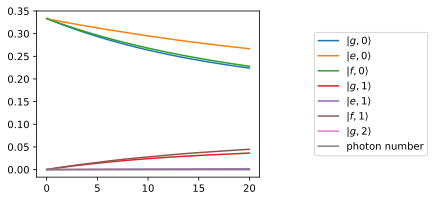

In [22]:
# resonator decay constant
kappa = 1000
tlist = np.linspace(0, 20, 1000)

def drive_coeff(t: float, *args: dict) -> float:
    return A * np.cos(omega_g0g1 * t)
H_with_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (a+a.dag()) , drive_coeff],  # driving through the resonator
]

superposition012 = 1/np.sqrt(3)*qutip.basis(total_truncation, hilbertspace.dressed_index((0,0)))\
                   +1/np.sqrt(3)*qutip.basis(total_truncation, hilbertspace.dressed_index((1,0)))\
                   +1/np.sqrt(3)*qutip.basis(total_truncation, hilbertspace.dressed_index((2,0)))
result = qutip.mesolve(
    H = H_with_drive,
    rho0 = superposition012,
    tlist = tlist,
    e_ops=[state * state.dag() for state in qutip_states]+[a.dag()*a],
    c_ops=[np.sqrt(kappa) * a],
    options=qutip.Options(store_final_state=True),
    progress_bar = True
)
fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))


for idx, res in zip(idxs, result.expect):
    product_state = product_states[idxs.index(idx)]
    qubit_state = dictionary[product_state[0]]
    resonator_state = product_state[1]
    ax1.plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
ax1.plot(tlist, result.expect[-1], label=r"photon number")
ax1.legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))

plt.show()

10.0%. Run time:  72.20s. Est. time left: 00:00:10:49
20.0%. Run time: 144.53s. Est. time left: 00:00:09:38
30.0%. Run time: 217.41s. Est. time left: 00:00:08:27
40.0%. Run time: 289.97s. Est. time left: 00:00:07:14
50.0%. Run time: 362.46s. Est. time left: 00:00:06:02
60.0%. Run time: 434.68s. Est. time left: 00:00:04:49
70.0%. Run time: 506.27s. Est. time left: 00:00:03:36
80.0%. Run time: 578.36s. Est. time left: 00:00:02:24
90.0%. Run time: 650.12s. Est. time left: 00:00:01:12
Total run time: 723.04s


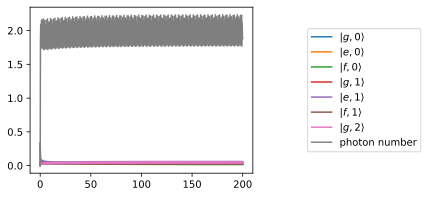

In [11]:
from math import sqrt
g0g1 = transition_frequency(hilbertspace.dressed_index((0,0)), hilbertspace.dressed_index((0,1)))
e0e1 = transition_frequency(hilbertspace.dressed_index((1,0)), hilbertspace.dressed_index((1,1)))
kappa = 2*abs(g0g1-e0e1)
omega_d = (e0e1+g0g1)/2
A = sqrt(10)*kappa

tlist = np.linspace(0, 200, 800)

def drive_coeff(t: float, *args: dict) -> float:
    return A * np.cos(omega_d * t)
H_with_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (a+a.dag()) , drive_coeff],  # driving through the resonator
]

superposition012 = 1/np.sqrt(3)*qutip.basis(total_truncation, hilbertspace.dressed_index((0,0)))\
                   +1/np.sqrt(3)*qutip.basis(total_truncation, hilbertspace.dressed_index((1,0)))\
                   +1/np.sqrt(3)*qutip.basis(total_truncation, hilbertspace.dressed_index((2,0)))
result = qutip.mesolve(
    H = H_with_drive,
    rho0 = superposition012,
    tlist = tlist,
    e_ops=[state * state.dag() for state in qutip_states]+[a.dag()*a],
    c_ops=[np.sqrt(kappa) * a],
    options=qutip.Options(store_final_state=True),
    progress_bar = True
)
fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))

dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}
for idx, res in zip(idxs, result.expect):
    product_state = product_states[idxs.index(idx)]
    qubit_state = dictionary[product_state[0]]
    resonator_state = product_state[1]
    ax1.plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
ax1.plot(tlist, result.expect[-1], label=r"photon number")
ax1.legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))

plt.show()

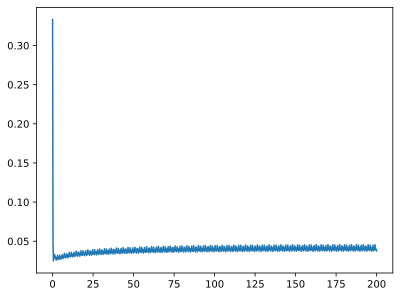

In [18]:
plt.plot(tlist,result.expect[0])

In [25]:
transition_frequency(hilbertspace.dressed_index((0,0)), hilbertspace.dressed_index((0,1)))

68.9807941330468